In [1]:
from nn import NeuralNetwork
from nn import preprocess
from nn import io
from sklearn.model_selection import train_test_split
import numpy as np

In [3]:
#Read in positive seqs and negative seqs and create labels for them (1 = TF, 0 = not TF)
#Resample the data and one hot encode it to prepare the data for NN training
#Split into test and train supsets

'''
EXPLANATION OF SAMPLING SCHEME: Because the TF sequences were all 17bp long, I needed to
split the data into groups of 17. Also, I know DNA is read in codons of three, which means
there are three possible reading frames. So I preprocessed the data to capture all of the
possible reading frames for the groups of 17 from the negative sequences. I then created
list of 1's and 0's corresponding to the negative and positive lists and mae those the
targets. For the actual sampling, the method randomly picks between 1 or 0, if it picks 1,
it then randomly grabs a positive sequence and label. If it picks 0, then it randomly selects
a negative sequence and label. This produces a random ~50/50 split of positive and negative
seqs for training. The sample seq also limits it to 10000 sequences for computational ease.
'''

pos_X = io.read_text_file('./data/rap1-lieb-positives.txt') #17bp
pos_y = [1] * len(pos_X)
neg_X_raw = io.read_fasta_file('./data/yeast-upstream-1k-negative.fa') #1000bp
neg_X = []
for seq in neg_X_raw:
    neg_len = int((len(seq)-1)/3)
    for idx in range(neg_len):
        idx = idx * 3
        snip = seq[idx:idx+17]
        if len(snip) == 17:
            neg_X.append(snip)
        snip = seq[idx+1:idx+18]
        if len(snip) == 17:
            neg_X.append(snip)
        snip = seq[idx+2:idx+19]
        if len(snip) == 17:
            neg_X.append(snip)
neg_y = [0] * len(neg_X)


sampled_seqs_pre, sampled_labels = preprocess.sample_seqs(pos_X, neg_X, pos_y, neg_y)
sampled_seqs = preprocess.one_hot_encode_seqs(sampled_seqs_pre)
X_train, X_test, y_train, y_test = train_test_split(sampled_seqs, sampled_labels,
                                                            test_size=0.15, random_state=42)

In [40]:
#Initialize the NN

'''
EXPLANATION OF HYPERPARAMETER CHOICE: I didn't automate the tuning of the hyperparameters, 
so I tuned by trial and error because the code didn't take too long to run. I found a learning
rate of .0002 to strike a balance between hitting a minimum quickly without become jagged
and overshooting. With those parameters, the elbow region was around 10 epochs, so I chose
that as the epoch number. Because I used the sigmoid activation fucntion, the the answers are
0 or 1, I used binary cross entropy as the loss function
'''

lr=.0002
seed=1
batch_size=2
epochs=10
nn = NeuralNetwork([{'input_dim': 68, 'output_dim': 32, 'activation': 'sigmoid'},
                    {'input_dim': 32, 'output_dim': 16, 'activation': 'sigmoid'},
                    {'input_dim': 16, 'output_dim': 4, 'activation': 'sigmoid'},
                    {'input_dim': 4, 'output_dim': 1, 'activation': 'sigmoid'}],
                   lr, seed, batch_size, epochs, 'binary cross entropy')

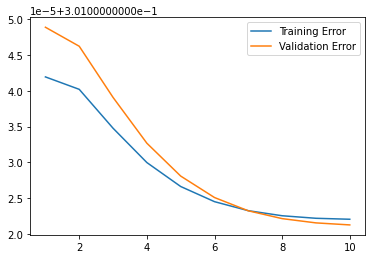

Average Training Error: 0.3010288219531233
Average Validation Error: 0.3010308312784321


In [41]:
#Fit the model and print errors
train_error, validation_error = nn.fit(X_train, y_train, X_test, y_test)
print(f'Average Training Error: {np.mean(train_error)}')
print(f'Average Validation Error: {np.mean(validation_error)}')